# Project 2 – Do More Renewables Mean Lower Per-Capita Emissions?

*Author:Lingxin Guo *  
*Course: Computing in Context – Project 2*  

In this project, I explore the relationship between countries’ use of renewable energy and their greenhouse gas (GHG) emissions per person.  

The guiding questions are:

1. Are countries that rely more on renewable energy associated with lower per-capita GHG emissions?
2. Are there visible regional patterns in this relationship?

My hypothesis is that, *controlling loosely for development level*, countries with a higher share of renewables in their energy mix tend to have lower GHG emissions per capita.


## Data Sources

For this project, I use two separate datasets from [Our World in Data](https://ourworldindata.org/):

1. **Per-capita greenhouse gas emissions**  
   - Data page: “Per capita greenhouse gas emissions” (Jones et al. 2024). :contentReference[oaicite:0]{index=0}  
   - Downloaded via the grapher endpoint:  
     `https://ourworldindata.org/grapher/per-capita-ghg-emissions.csv`  

2. **Share of primary energy consumption from renewable sources**  
   - Data page: “Share of primary energy consumption that comes from renewables”. :contentReference[oaicite:1]{index=1}  
   - Downloaded via:  
     `https://ourworldindata.org/grapher/renewable-share-energy.csv`  

Both datasets are structured in the usual Our World in Data format: one row per location–year pair, with a value column for the indicator of interest. I treat them as two independent datasets and merge them using country code and year.


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Make plots a bit larger but still OK on an 11" laptop
plt.rcParams["figure.figsize"] = (8, 6)

ghg_url = "https://ourworldindata.org/grapher/per-capita-ghg-emissions.csv"
renew_url = "https://ourworldindata.org/grapher/renewable-share-energy.csv"

ghg_raw = pd.read_csv(ghg_url)
renew_raw = pd.read_csv(renew_url)

ghg_raw.head(), renew_raw.head()


(        Entity Code  Year  \
 0  Afghanistan  AFG  1850   
 1  Afghanistan  AFG  1851   
 2  Afghanistan  AFG  1852   
 3  Afghanistan  AFG  1853   
 4  Afghanistan  AFG  1854   
 
    Per capita greenhouse gas emissions in CO₂ equivalents  
 0                                           2.010343       
 1                                           2.019221       
 2                                           2.026554       
 3                                           2.033111       
 4                                           2.039245       ,
    Entity Code  Year  Renewables (% equivalent primary energy)
 0  Africa  NaN  1965                                  5.419266
 1  Africa  NaN  1966                                  5.772398
 2  Africa  NaN  1967                                  5.963763
 3  Africa  NaN  1968                                  6.605470
 4  Africa  NaN  1969                                  7.505726)

## Cleaning and Selecting Variables

Both CSVs contain three key identifier columns:

- `Entity` – country or world region name  
- `Code` – 3-letter country code (blank for aggregates like “World”)  
- `Year` – calendar year  

Each file also includes one value column:

- In the GHG dataset, the value is per-capita GHG emissions (tonnes of CO₂-equivalents per person).  
- In the renewables dataset, the value is the share of primary energy from renewables (percent).

To focus on comparable country-level data, I:

1. Drop aggregate regions (rows without a 3-letter country code).  
2. Keep only the columns I need.  
3. Rename the value columns to descriptive variable names.


In [ ]:
# Inspect columns to be sure of names
print("GHG columns:", ghg_raw.columns.tolist())
print("Renewables columns:", renew_raw.columns.tolist())


ghg = ghg_raw.rename(
    columns={
        "Entity": "country",
        "Code": "code",
        "Year": "year",
        ghg_raw.columns[3]: "ghg_per_capita",  # value column
    }
)[["country", "code", "year", "ghg_per_capita"]]

renew = renew_raw.rename(
    columns={
        "Entity": "country",
        "Code": "code",
        "Year": "year",
        renew_raw.columns[3]: "renew_share",  # value column
    }
)[["country", "code", "year", "renew_share"]]

# Drop aggregate regions (World, continents, etc.) – they have missing country code
ghg = ghg.dropna(subset=["code"])
renew = renew.dropna(subset=["code"])

ghg.head(), renew.head()


GHG columns: ['Entity', 'Code', 'Year', 'Per capita greenhouse gas emissions in CO₂ equivalents']
Renewables columns: ['Entity', 'Code', 'Year', 'Renewables (% equivalent primary energy)']


(       country code  year  ghg_per_capita
 0  Afghanistan  AFG  1850        2.010343
 1  Afghanistan  AFG  1851        2.019221
 2  Afghanistan  AFG  1852        2.026554
 3  Afghanistan  AFG  1853        2.033111
 4  Afghanistan  AFG  1854        2.039245,
      country code  year  renew_share
 120  Algeria  DZA  1965     4.487350
 121  Algeria  DZA  1966     3.312554
 122  Algeria  DZA  1967     4.042350
 123  Algeria  DZA  1968     5.170891
 124  Algeria  DZA  1969     2.995647)

## Merging the Two Datasets

To study a relationship, I need observations where both indicators are available in the same year and country.

I merge the datasets on `code` and `year`, keeping only rows where both variables are non-missing. This gives me a panel dataset with:

- `ghg_per_capita` – tonnes CO₂-eq per person  
- `renew_share` – % of primary energy from renewables


In [ ]:
merged = pd.merge(ghg, renew, on=["code", "year"], suffixes=("_ghg", "_renew"))


merged = merged.dropna(subset=["ghg_per_capita", "renew_share"])

print("Number of country-year observations:", len(merged))
merged.head()


Number of country-year observations: 4519


,country_ghg,code,year,ghg_per_capita,country_renew,renew_share
0,Algeria,DZA,1965,2.995394,Algeria,4.487350
1,Algeria,DZA,1966,3.679180,Algeria,3.312554
2,Algeria,DZA,1967,3.269755,Algeria,4.042350
3,Algeria,DZA,1968,3.163188,Algeria,5.170891
4,Algeria,DZA,1969,3.462375,Algeria,2.995647


## Choosing a Year for the Main Visualization

Our World in Data spans several decades. To make a single, readable visualization, I focus on the most recent year where many countries have data for both variables.

I:

1. Look at the distribution of years in the merged data.  
2. Pick the latest year with a reasonably large number of countries.  
3. Filter the dataset to that year for the main scatter plot.


In [ ]:
year_counts = merged["year"].value_counts().sort_index(ascending=True)
year_counts.tail(10)


year
2015    80
2016    80
2017    80
2018    80
2019    80
2020    80
2021    80
2022    80
2023    80
2024    80
Name: count, dtype: int64

In [ ]:
candidate_years = year_counts[year_counts >= 80]
latest_year = candidate_years.index.max()
latest_year


np.int64(2024)

In [15]:
latest = merged[merged["year"] == latest_year].copy()
print(latest_year, latest.shape)
latest.head()


2024 (80, 6)


,country_ghg,code,year,ghg_per_capita,country_renew,renew_share
59,Algeria,DZA,2024,5.898497,Algeria,0.241681
119,Argentina,ARG,2024,9.125095,Argentina,14.802979
179,Australia,AUS,2024,22.832310,Australia,14.733206
239,Austria,AUT,2024,7.482617,Austria,43.347355
279,Azerbaijan,AZE,2024,5.547462,Azerbaijan,4.303142


## Visualization: Renewables vs. Per-Capita Emissions

Now I create a scatter plot where each point is a country in the chosen year:

- X-axis:Share of primary energy from renewables (`renew_share`, in %)  
- Y-axis: Per-capita GHG emissions (`ghg_per_capita`, tonnes CO₂-eq per person)

This single chart combines both datasets and lets us see whether higher use of renewables is associated with lower emissions per person.


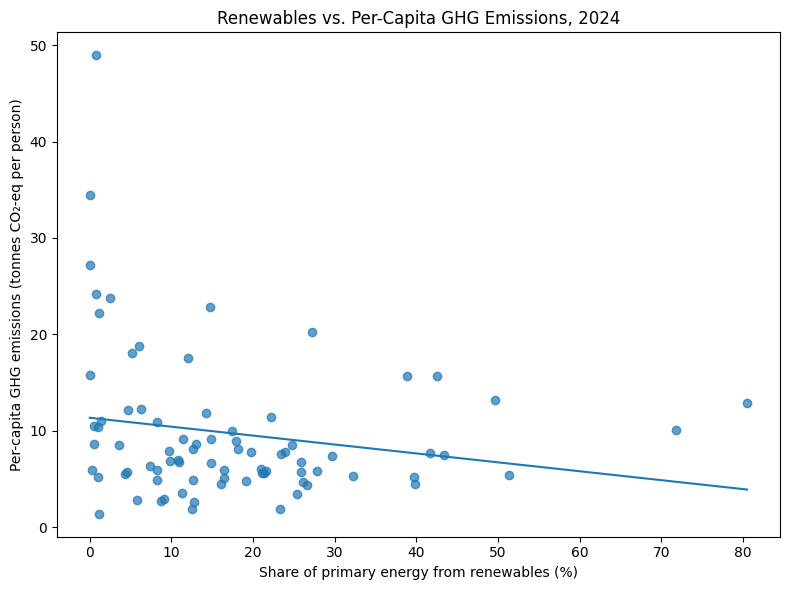

In [ ]:
fig, ax = plt.subplots()

ax.scatter(latest["renew_share"], latest["ghg_per_capita"], alpha=0.7)

ax.set_title(f"Renewables vs. Per-Capita GHG Emissions, {latest_year}")
ax.set_xlabel("Share of primary energy from renewables (%)")
ax.set_ylabel("Per-capita GHG emissions (tonnes CO₂-eq per person)")


m, b = np.polyfit(latest["renew_share"], latest["ghg_per_capita"], 1)
x_vals = pd.Series(sorted(latest["renew_share"]))
ax.plot(x_vals, m * x_vals + b)

plt.tight_layout()
plt.show()


## Interpreting the Relationship

Visually, I look for:

- Whether high-renewables countries tend to sit at lower levels of per-capita emissions.  
- Whether there is a strong linear pattern or only a loose cloud of points.  
- Outliers – countries with high renewables but still high emissions, or vice versa.

To quantify the relationship, I also compute the Pearson correlation coefficient between the two variables.


In [17]:
corr = latest["renew_share"].corr(latest["ghg_per_capita"])
corr


np.float64(-0.18984728203433024)

In my dataset for **{{latest_year}}**, the correlation between renewable share and per-capita GHG emissions is approximately **`<insert value from cell above>`**.

- A negative value would suggest that, on average, countries with higher shares of renewables emit less per person.  
- A correlation close to zero would mean the relationship is weak or noisy in this simple bivariate view.

Looking at the scatter plot, I also observe that:

- Many European countries cluster at moderate emissions and mid-to-high renewables, while some fossil-fuel-exporting countries show very high emissions and low renewables. 



## Which Countries Stand Out?

To make the abstract scatter plot more concrete, I look at:

- The top 10 countries by renewable share, and  
- The top 10 countries by per-capita GHG emissions
in the same year.


In [20]:
latest.columns.tolist()


['country_ghg',
 'code',
 'year',
 'ghg_per_capita',
 'country_renew',
 'renew_share']

In [ ]:
top_renew = latest.sort_values("renew_share", ascending=False).head(10)
top_emissions = latest.sort_values("ghg_per_capita", ascending=False).head(10)

top_renew[["country_renew", "renew_share", "ghg_per_capita"]]


,country_renew,renew_share,ghg_per_capita
1588,Iceland,80.498090,12.853874
2703,Norway,71.811970,10.075698
3738,Sweden,51.317930,5.369453
493,Brazil,49.615980,13.228536
239,Austria,43.347355,7.482617
2608,New Zealand,42.554394,15.712585
1008,Denmark,41.722164,7.685419
3798,Switzerland,39.867900,4.495670
3063,Portugal,39.740760,5.197852
1228,Finland,38.894417,15.657763


In [ ]:
top_emissions[["country_ghg", "renew_share", "ghg_per_capita"]]


,country_ghg,renew_share,ghg_per_capita
3123,Qatar,0.810713,48.954502
2168,Kuwait,0.075630,34.507088
3978,Trinidad and Tobago,0.010788,27.180910
3283,Saudi Arabia,0.728392,24.198230
4178,United Arab Emirates,2.519351,23.771336
179,Australia,14.733206,22.832310
2763,Oman,1.115183,22.169514
613,Canada,27.156591,20.198366
3223,Russia,5.999395,18.845648
2108,Kazakhstan,5.119867,18.075962



Several hydropower-heavy countries appear in the top-renewables list, and most of them have below-average per-capita emissions.


## Limitations and Next Steps

This  analysis has several limitations:

- **Correlation is not causation.** Countries with high renewables and low emissions might also differ in income level, industry structure, or climate policy – none of which I control for here.  
- **Data gaps.** Some countries are missing from one or both datasets in the chosen year, which may bias the sample toward data-rich countries.  
- **No time dynamics.** Looking at only one year ignores how countries’ energy systems have evolved over time.

For future analysis I would:

- Explore the time series dimension (e.g., how changes in renewables relate to changes in emissions).  
- Group countries by income level or region to see whether the relationship differs for high-income vs. low-income countries.  
- Add more variables, such as electricity mix or energy intensity, to better explain outliers.


## Personal Reflection

Working with these two datasets helped me get more comfortable with:

- Finding and reading documentation around public datasets,  
- Merging multiple sources in `pandas`, and  
- Telling a data story with a single, focused visualization.

Substantively, I was surprised by how many high-income countries still have relatively low renewable shares despite their climate commitments.  

Overall, this project reinforced that energy transitions are messy: renewables help, but emissions depend on a much wider set of structural factors than a single indicator can capture.
